Time-Series Prediction
Time series and sequence prediction could be a really amazing to predict/estimate a robot's trajectory which requires temporal data at hand. In this assignemnt we will see how this could be done using Deep Learning.

Given a dataset [link](https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv) for airline passengers prediction problem. Predict the number of international airline passengers in units of 1,000 given a year and a month.
Here is how the data looks like.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
file_name = 'airline-passengers.csv' # dataset path
# Reading data using pandas or csv
df = pd.read_csv(file_name)

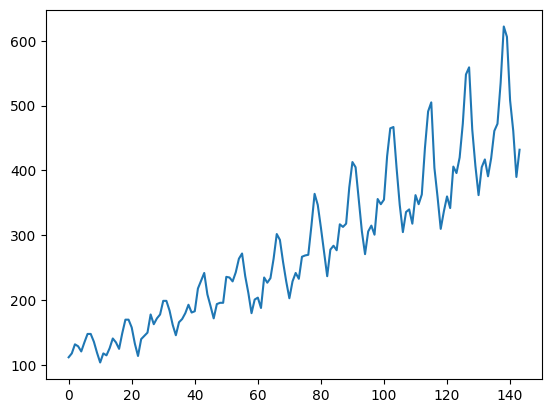

In [2]:
# plotting the dataset
timeseries = df[["Passengers"]].values.astype('float32')
# plotting the dataset
plt.plot(timeseries)
plt.show()

# **Pytorch LSTM Implementation**


# Pre-Processing the Data

In [3]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

xy = np.loadtxt('airline-passengers.csv', delimiter=",", dtype=np.object_, skiprows=1)
Training_set = torch.from_numpy(np.array([int(string[1]) for string in xy]))
Training_set = torch.reshape(Training_set, (Training_set.shape[0], 1))

print(Training_set.shape)

set_to_scale_features = []
set_to_scale_labels = []

# Loop through the array to create the feature and label sets
for i in range(24, Training_set.shape[0]):
    set_to_scale_features.append(Training_set[i-24:i, 0])
    set_to_scale_labels.append(Training_set[i, 0])

# Convert lists to NumPy arrays
set_to_scale_features = np.array(set_to_scale_features)
set_to_scale_labels = np.array(set_to_scale_labels)

# Reshape the feature set
set_to_scale_features = torch.from_numpy(set_to_scale_features.reshape(set_to_scale_features.shape[0], set_to_scale_features.shape[1]))

# Convert labels to PyTorch tensor
set_to_scale_labels = torch.from_numpy(set_to_scale_labels.reshape(set_to_scale_labels.shape[0], 1))

print(set_to_scale_features.shape)
print(set_to_scale_labels.shape)

combined_dataset = torch.cat((set_to_scale_features, set_to_scale_labels), dim=1)

combined_dataset = pd.DataFrame(combined_dataset.numpy())
combined_dataset

torch.Size([144, 1])
torch.Size([120, 24])
torch.Size([120, 1])


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,112,118,132,129,121,135,148,148,136,119,...,135,125,149,170,170,158,133,114,140,145
1,118,132,129,121,135,148,148,136,119,104,...,125,149,170,170,158,133,114,140,145,150
2,132,129,121,135,148,148,136,119,104,118,...,149,170,170,158,133,114,140,145,150,178
3,129,121,135,148,148,136,119,104,118,115,...,170,170,158,133,114,140,145,150,178,163
4,121,135,148,148,136,119,104,118,115,126,...,170,158,133,114,140,145,150,178,163,172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,505,404,359,310,337,360,342,406,396,420,...,362,405,417,391,419,461,472,535,622,606
116,404,359,310,337,360,342,406,396,420,472,...,405,417,391,419,461,472,535,622,606,508
117,359,310,337,360,342,406,396,420,472,548,...,417,391,419,461,472,535,622,606,508,461
118,310,337,360,342,406,396,420,472,548,559,...,391,419,461,472,535,622,606,508,461,390


In [4]:
# Scaling the Combined Dataset
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
scaled_set = sc.fit_transform(combined_dataset)
scaled_set

array([[0.01995012, 0.03491272, 0.06982544, ..., 0.        , 0.        ,
        0.        ],
       [0.03491272, 0.06982544, 0.06234414, ..., 0.0511811 , 0.01037344,
        0.01048218],
       [0.06982544, 0.06234414, 0.04239401, ..., 0.06102362, 0.02074689,
        0.06918239],
       ...,
       [0.63591022, 0.51371571, 0.58104738, ..., 0.96850394, 0.76348548,
        0.66247379],
       [0.51371571, 0.58104738, 0.63840399, ..., 0.77559055, 0.6659751 ,
        0.51362683],
       [0.58104738, 0.63840399, 0.59351621, ..., 0.68307087, 0.5186722 ,
        0.60167715]])

In [5]:
# Extracting X and Y data from the scaled array
X = scaled_set[:, :-1]
Y = scaled_set[:, -1]

print(X.shape, Y.shape)

# # Flip the X data so that data from the oldest and the last entry is the latest data
# X =dc(np.flip(X, axis = 1))
# X

# #  Index to provide the number of entries in the Training and Testing Data respectively
split_index = int(len(X) * 0.8)

# split_index

# # Spliting the data as per the split_index
X_train = X[:split_index]
X_test = X[split_index:]

Y_train = Y[:split_index]
Y_test = Y[split_index:]

lookback = 24
# # Reshaping the data in sets (Adding a dimension for indicators)
X_train = X_train.reshape((-1, lookback, 1))
X_test =  X_test.reshape((-1, lookback, 1))

Y_train = Y_train.reshape((-1, 1))
Y_test = Y_test.reshape((-1, 1))

# # Converting the data in tensor form
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
Y_train = torch.tensor(Y_train).float()
Y_test = torch.tensor(Y_test).float()

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

# # Creating dataset objects to process nn data through pytorch
from torch.utils.data import Dataset

class TSA(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __getitem__(self, index) :
    return self.X[index], self.Y[index]

  def __len__(self):
    return len(self.X)

train_dataset = TSA(X_train, Y_train)
test_dataset = TSA(X_test, Y_test)

# train_dataset

# # Using data_loader to classify data in required format
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Print the batch sizes to confirm
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape)
  break

(120, 24) (120,)
torch.Size([16, 24, 1]) torch.Size([16, 1])


# LSTM Training

In [ ]:
# Importing the data from CSV
import numpy as np
import torch
import torch.nn as nn
# Creating a Pytorch LSTM nn model to train the model. Didnt use droput in this case as it gave better results
# Used 70 hidden layers in a layer and used two such LSTM layer
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm1 = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True, dropout=dropout)

        # self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_stacked_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_stacked_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm1(x, (h0, c0))
        # out = self.dropout(out)

        out = self.fc(out[:, -1, :])
        return out

# Define the hyperparameters
input_size = 1
hidden_size = 70
num_stacked_layers = 3

# Initialize the model
model = LSTMModel(input_size, hidden_size, num_stacked_layers, dropout=0.0)
model.to(device)
model

LSTMModel(
  (lstm1): LSTM(1, 70, num_layers=3, batch_first=True)
  (fc): Linear(in_features=70, out_features=1, bias=True)
)

In [ ]:
import torch.optim as optim
learning_rate = 0.001
num_epochs = 500

# Define your loss function
loss_function = nn.MSELoss()

# Define your optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Running epochs
for epoch in range(num_epochs):
    # Set model to training mode
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(batch_index)
        if batch_index % 2 == 1:
          avg_loss_across_batches = running_loss / 100
          print('Batch {0}, Loss: {1: .3f}'.format(batch_index+1, avg_loss_across_batches))

# Validate every epoch
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
          output = model(x_batch)
          loss = loss_function(output, y_batch)
          running_loss += loss

    avg_loss_across_batches = running_loss / len(test_loader)
    print('Validation Loss {0: .3f}'.format(avg_loss_across_batches))

    print('###################################################')

    running_loss = 0.0


Epoch: 1
Batch 2, Loss:  0.002
Batch 4, Loss:  0.003
Batch 6, Loss:  0.004
Validation Loss  0.252
###################################################
Epoch: 2
Batch 2, Loss:  0.001
Batch 4, Loss:  0.001
Batch 6, Loss:  0.002
Validation Loss  0.142
###################################################
Epoch: 3
Batch 2, Loss:  0.001
Batch 4, Loss:  0.001
Batch 6, Loss:  0.002
Validation Loss  0.178
###################################################
Epoch: 4
Batch 2, Loss:  0.001
Batch 4, Loss:  0.001
Batch 6, Loss:  0.002
Validation Loss  0.201
###################################################
Epoch: 5
Batch 2, Loss:  0.001
Batch 4, Loss:  0.001
Batch 6, Loss:  0.002
Validation Loss  0.185
###################################################
Epoch: 6
Batch 2, Loss:  0.001
Batch 4, Loss:  0.001
Batch 6, Loss:  0.002
Validation Loss  0.144
###################################################
Epoch: 7
Batch 2, Loss:  0.001
Batch 4, Loss:  0.001
Batch 6, Loss:  0.002
Validation Loss  0.115
##

# LSTM Plotting

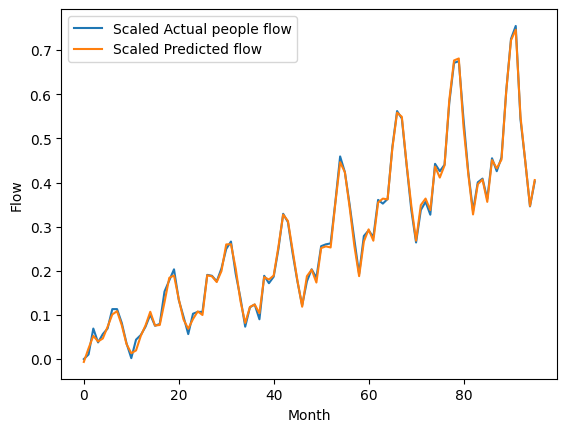

In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(Y_train, label='Scaled Actual people flow')
plt.plot(predicted, label='Scaled Predicted flow')
plt.xlabel('Month')
plt.ylabel('Flow')
plt.legend()
plt.show()


In [ ]:
from copy import deepcopy as dc
train_predictions = predicted.flatten()

fitter = np.zeros((X_train.shape[0], lookback+1))
fitter[:, 0] = train_predictions
fitter = sc.inverse_transform(fitter)

train_predictions = dc(fitter[:, 0])
train_predictions

fitter = np.zeros((X_train.shape[0], lookback+1))
fitter[:, 0] = Y_train.flatten()
fitter = sc.inverse_transform(fitter)

new_y_train = dc(fitter[:, 0])

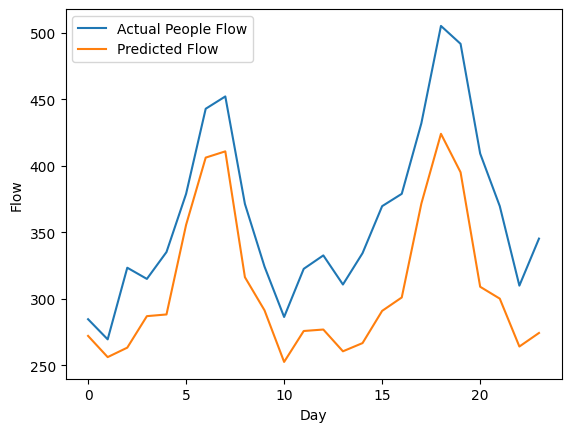

In [ ]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

fitter = np.zeros((X_test.shape[0], lookback+1))
fitter[:, 0] = test_predictions
fitter = sc.inverse_transform(fitter)

test_predictions = dc(fitter[:, 0])

fitter = np.zeros((X_test.shape[0], lookback+1))
fitter[:, 0] = Y_test.flatten()
fitter = sc.inverse_transform(fitter)

new_y_test = dc(fitter[:, 0])


plt.plot(new_y_test, label='Actual People Flow')
plt.plot(test_predictions, label='Predicted Flow')
plt.xlabel('Day')
plt.ylabel('Flow')
plt.legend()
plt.show()


# **Pytorch RNN Implementation**
Use the Preprocessig cells to gather data before execution.

In [ ]:
class RNNmodel(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_stacked_layers, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_stacked_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.rnn(x, (h0))

        out = self.fc(out[:, -1, :])
        return out

# Define the hyperparameters
input_size = 1
hidden_size = 70
num_stacked_layers = 3

# Initialize the model
model = RNNmodel(input_size, hidden_size, num_stacked_layers, dropout=0.0)
model.to(device)
model

RNNmodel(
  (rnn): RNN(1, 70, num_layers=3, batch_first=True)
  (fc): Linear(in_features=70, out_features=1, bias=True)
)

In [ ]:
import torch.optim as optim
learning_rate = 0.001
num_epochs = 500

# Define your loss function
loss_function = nn.MSELoss()

# Define your optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Running epochs
for epoch in range(num_epochs):
    # Set model to training mode
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(batch_index)
        if batch_index % 2 == 1:
          avg_loss_across_batches = running_loss / 100
          print('Batch {0}, Loss: {1: .3f}'.format(batch_index+1, avg_loss_across_batches))

# Validate every epoch
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
          output = model(x_batch)
          loss = loss_function(output, y_batch)
          running_loss += loss

    avg_loss_across_batches = running_loss / len(test_loader)
    print('Validation Loss {0: .3f}'.format(avg_loss_across_batches))

    print('####################################################')

    running_loss = 0.0


Epoch: 1
Batch 2, Loss:  0.002
Batch 4, Loss:  0.003
Batch 6, Loss:  0.004
Validation Loss  0.090
####################################################
Epoch: 2
Batch 2, Loss:  0.001
Batch 4, Loss:  0.002
Batch 6, Loss:  0.002
Validation Loss  0.267
####################################################
Epoch: 3
Batch 2, Loss:  0.001
Batch 4, Loss:  0.001
Batch 6, Loss:  0.002
Validation Loss  0.147
####################################################
Epoch: 4
Batch 2, Loss:  0.001
Batch 4, Loss:  0.001
Batch 6, Loss:  0.002
Validation Loss  0.114
####################################################
Epoch: 5
Batch 2, Loss:  0.000
Batch 4, Loss:  0.001
Batch 6, Loss:  0.002
Validation Loss  0.139
####################################################
Epoch: 6
Batch 2, Loss:  0.001
Batch 4, Loss:  0.001
Batch 6, Loss:  0.001
Validation Loss  0.028
####################################################
Epoch: 7
Batch 2, Loss:  0.000
Batch 4, Loss:  0.000
Batch 6, Loss:  0.001
Validation Loss  0.

# RNN Plotting

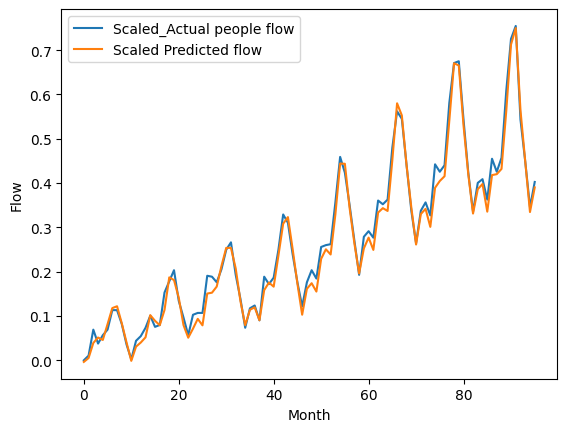

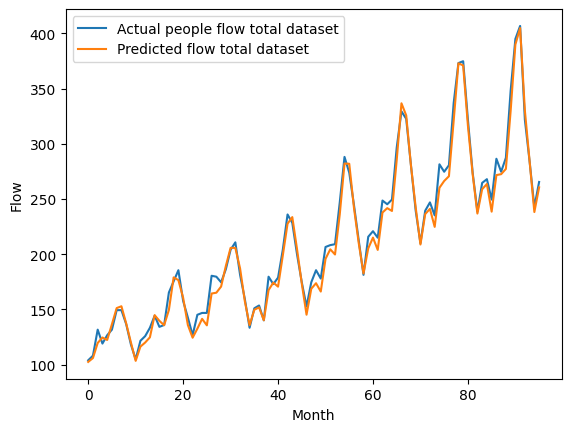

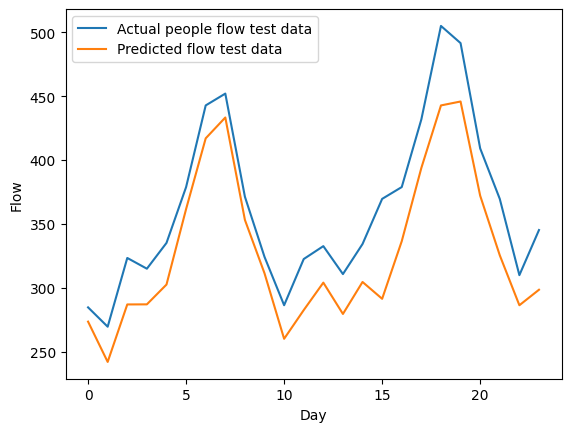

In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(Y_train, label='Scaled_Actual people flow')
plt.plot(predicted, label='Scaled Predicted flow')
plt.xlabel('Month')
plt.ylabel('Flow')
plt.legend()
plt.show()

# Plotting Actual and Predicted Flow on training Dataset
train_predictions = predicted.flatten()

fitter = np.zeros((X_train.shape[0], lookback+1))
fitter[:, 0] = train_predictions
fitter = sc.inverse_transform(fitter)

train_predictions = dc(fitter[:, 0])
train_predictions

fitter = np.zeros((X_train.shape[0], lookback+1))
fitter[:, 0] = Y_train.flatten()
fitter = sc.inverse_transform(fitter)

new_y_train = dc(fitter[:, 0])
new_y_train

plt.plot(new_y_train, label='Actual people flow total dataset')
plt.plot(train_predictions, label='Predicted flow total dataset')
plt.xlabel('Month')
plt.ylabel('Flow')
plt.legend()
plt.show()

test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

fitter = np.zeros((X_test.shape[0], lookback+1))
fitter[:, 0] = test_predictions
fitter = sc.inverse_transform(fitter)

test_predictions = dc(fitter[:, 0])
# test_predictions

fitter = np.zeros((X_test.shape[0], lookback+1))
fitter[:, 0] = Y_test.flatten()
fitter = sc.inverse_transform(fitter)

new_y_test = dc(fitter[:, 0])
# new_y_test

plt.plot(new_y_test, label='Actual people flow test data')
plt.plot(test_predictions, label='Predicted flow test data')
plt.xlabel('Day')
plt.ylabel('Flow')
plt.legend()
plt.show()


# **Tensorflow RNN Implementation**

In [8]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
from sklearn.model_selection import train_test_split

class passengers(Dataset):
  def __init__(self):
    xy = np.loadtxt('airline-passengers.csv', delimiter=",", dtype=np.object_, skiprows=1)
    Y = torch.from_numpy(np.array([int( str(string[0][3:5]) + str(string[0][6:-1])) for string in xy]))
    self.Training_set = torch.from_numpy(np.array([int( str(string[1])) for string in xy]))
    self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.Training_set, Y, test_size = 0.2)
    self.n_samples = xy.shape[0]

  def __getitem__(self, index) :
    return self.X[index], self.Y[index]

  def __len__(self):
    return self.n_samples

dataset = passengers()
print(dataset.X_train.shape)

# Pre-processing the Data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
scaled_training_set = sc.fit_transform(dataset.X_train.reshape(-1,1))

# Creating a data structure with 24 previous timesteps and 1 output
# print(dataset.X_train.shape)

X_train = []
Y_train = []
for i in range(24, scaled_training_set.shape[0]):
  X_train.append(scaled_training_set[i-24:i, 0])
  Y_train.append(scaled_training_set[i, 0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
# print(X_train.shape)
# print(Y_train.shape)

# # Reshaping (Adding a dimension for indicators)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_test = np.reshape(dataset.X_test, (dataset.X_test.shape[0], dataset.X_test.shape[1], 1))
print(X_train.shape)
print(Y_train.shape)
print(dataset.X_test.shape)
print(dataset.Y_test.shape)

torch.Size([115])
(91, 24, 1)
(91,)
torch.Size([29])
torch.Size([29])


In [9]:
# Building the RNN

# Importing the Library
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
model = Sequential()

# Adding the first LSTM layer and some Dropout Regularisation
model.add(LSTM(units=60, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding the second LSTM layer and some Dropout Regularisation
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))

# Adding the third LSTM layer and some Dropout Regularisation
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))

# Adding the fourth LSTM layer and some Dropout Regularisation
model.add(LSTM(units=70))
model.add(Dropout(0.2))

# Adding the Output Layer
model.add(Dense(units=1))


3. Evaluate and Compare the result using proper metric. Justify the metrics used.


In [10]:
# Compiling the RNN
model.compile(optimizer='adam', loss= 'mean_squared_error', metrics= ['mae','mape'])

# Fitting the RNN to the training set
model.fit(X_train, Y_train, epochs = 500, batch_size=24)

Epoch 1/500
4/4 [==============================] - 8s 56ms/step - loss: 0.1367 - mae: 0.2905 - mape: 1285142.6250
Epoch 2/500
4/4 [==============================] - 0s 51ms/step - loss: 0.0762 - mae: 0.2352 - mape: 5673079.0000
Epoch 3/500
4/4 [==============================] - 0s 77ms/step - loss: 0.0578 - mae: 0.2037 - mape: 4346541.5000
Epoch 4/500
4/4 [==============================] - 0s 83ms/step - loss: 0.0652 - mae: 0.2101 - mape: 3349426.0000
Epoch 5/500
4/4 [==============================] - 0s 81ms/step - loss: 0.0565 - mae: 0.2059 - mape: 3501022.0000
Epoch 6/500
4/4 [==============================] - 0s 81ms/step - loss: 0.0612 - mae: 0.2153 - mape: 3970994.2500
Epoch 7/500
4/4 [==============================] - 0s 83ms/step - loss: 0.0545 - mae: 0.2028 - mape: 4025066.5000
Epoch 8/500
4/4 [==============================] - 0s 86ms/step - loss: 0.0572 - mae: 0.2040 - mape: 3683303.7500
Epoch 9/500
4/4 [==============================] - 0s 85ms/step - loss: 0.0553 - mae: 0.

In [11]:
# Concatenating the test train and analysing the
dataset_total = np.concatenate((dataset.X_train, dataset.X_test))
print(dataset_total.shape)
inputs = dataset_total[len(dataset_total) - len(dataset.X_test) - 24:]
print(inputs.shape)
inputs = inputs.reshape(-1, 1)
print(inputs.shape)
inputs = sc.transform(inputs)

X_test = []
for i in range(24, 48):
  X_test.append(inputs[i-24:i, 0])
X_test = np.array(X_test)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_number = model.predict(X_test)
predicted_number = sc.inverse_transform(predicted_number)
print(predicted_number)

(144,)
(53,)
(53, 1)
(24, 24)
1/1 [==============================] - 2s 2s/step
[[283.76315]
 [301.5278 ]
 [301.39966]
 [291.686  ]
 [310.29355]
 [326.70242]
 [306.52127]
 [307.71216]
 [332.2549 ]
 [356.7575 ]
 [376.61392]
 [381.5616 ]
 [345.158  ]
 [307.98593]
 [276.86444]
 [269.17712]
 [291.1501 ]
 [290.53354]
 [311.42957]
 [320.54755]
 [318.8332 ]
 [326.4408 ]
 [310.4975 ]
 [301.76147]]


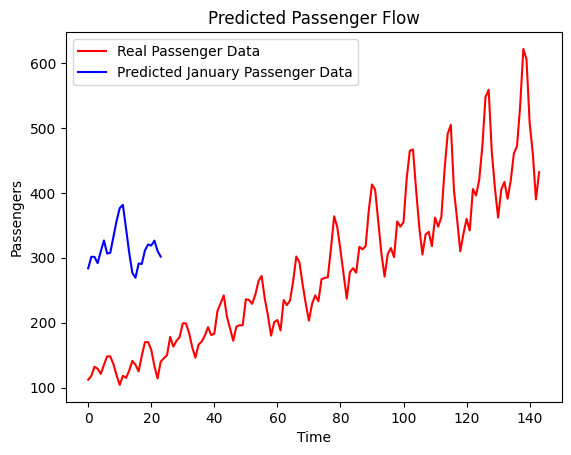

In [12]:
# Plot the Data
import matplotlib.pyplot as plt
plt.plot(dataset.Training_set, color = 'red', label = 'Real Passenger Data')
plt.plot(predicted_number, color = 'blue', label = 'Predicted January Passenger Data')
plt.title('Predicted Passenger Flow')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.show()

[Bonus 5 points] Suggest some things that could be done to improve the results.


Ans - To improve the performance of RNN three things can be done. \\
1. Training the RNN through enough epochs for the result to converge appropriately using ADAM optimizer to not allow the gradients to decay and automatically adjust learning rate to allow faster convergence.
2. Choose enough LSTM model cells to allow appropriate feature extraction and rejection.
3. Propose proper Dropout Regularisation to avoid overfitting of data by making the network more robust to noise.

[Bonus 5 points] Suggest where this could be used in Robotics other than the example given in the beginning.

RNNs can be used to model and control dynamic systems such as manipulator arms or mobile robots. By learning the dynamics of the system from sensor data, RNNs can predict future states and generate control signals to achieve desired behaviors.